# Twitter Integrated Bot in the Identification of Misinformation and Propogation Prevention

## Classification Dataset

### Victor Chua 019219 UCOMS

In [1]:
# Import necessary libraries
import re
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="darkgrid")
sns.set(font_scale=1.5)
import string
from nltk.corpus import stopwords
import collections
from pprint import pprint
from time import time

# nltk
from nltk.stem import WordNetLemmatizer

# sklearn for model training
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline, FeatureUnion, make_pipeline
from sklearn import model_selection

# sklearn evaluation metrics
from sklearn.metrics import classification_report,accuracy_score, plot_confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import auc

#warnings
import warnings
warnings.filterwarnings('ignore')

In [11]:
df = pd.read_csv(r'C:\Users\vcmc4\Desktop\Classes\FYP\FYP Codes & Dataset\Covid Datasets\merge.csv')
df.head()

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


In [3]:
train = pd.read_excel(r'C:\Users\vcmc4\Desktop\Classes\FYP\FYP Codes & Dataset\Covid Datasets\Constraint_English_Train.xlsx')
train.describe()

,id
count,6420.000000
mean,3210.500000
std,1853.438696
min,1.000000
25%,1605.750000
50%,3210.500000
75%,4815.250000
max,6420.000000


In [8]:
val = pd.read_excel(r'C:\Users\vcmc4\Desktop\Classes\FYP\FYP Codes & Dataset\Covid Datasets\Constraint_English_Val.xlsx')
val.describe()

,id
count,2140.000000
mean,1070.500000
std,617.909109
min,1.000000
25%,535.750000
50%,1070.500000
75%,1605.250000
max,2140.000000


In [9]:
test = pd.read_excel(r'C:\Users\vcmc4\Desktop\Classes\FYP\FYP Codes & Dataset\Covid Datasets\Constraint_English_Test.xlsx')
test.describe()

,id
count,2140.000000
mean,1070.500000
std,617.909109
min,1.000000
25%,535.750000
50%,1070.500000
75%,1605.250000
max,2140.000000


In [5]:
# Convert the string "label" column to category column
df['label'] = df["label"].astype('category')

In [6]:
# Check for Missing Values in dataset If Any
print("\nRows with empty column data in dataset:\n", df.isna().sum())


Rows with empty column data in dataset:
 tweet    0
label    0
dtype: int64


Total number of tweets labelled as "fake" is 4080.
Total number of tweets labelled as "real" is 4480.



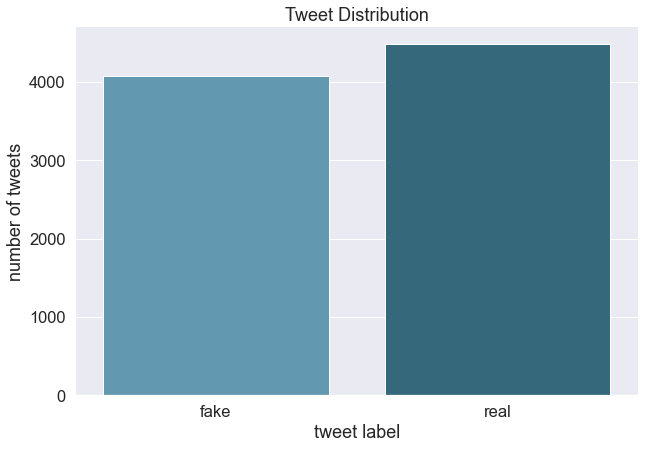

In [7]:
#show total number of email labelled as "fake" and total number of email labeled with "real"
print("Total number of tweets labelled as \"fake\" is %d."  %df["tweet"][df["label"]=="fake"].count())
print("Total number of tweets labelled as \"real\" is %d.\n"%df["tweet"][df["label"]=="real"].count())

#plot the graph to show how many ham and spam email are there in the spam ham dataset
sns.catplot(x="label", data=df, kind="count", height=6, aspect=1.5, palette="PuBuGn_d")
plt.xlabel("tweet label")
plt.ylabel("number of tweets")
plt.title("Tweet Distribution")
plt.show()

### Graph of distribution of the number of words in a tweet text per label class

Word Count
Fake: 21.679411764705883
Real: 31.74575892857143
Character Count
Fake: 143.51519607843136
Real: 215.37433035714287
Unique Word Count
Fake: 19.90514705882353
Real: 28.510044642857142


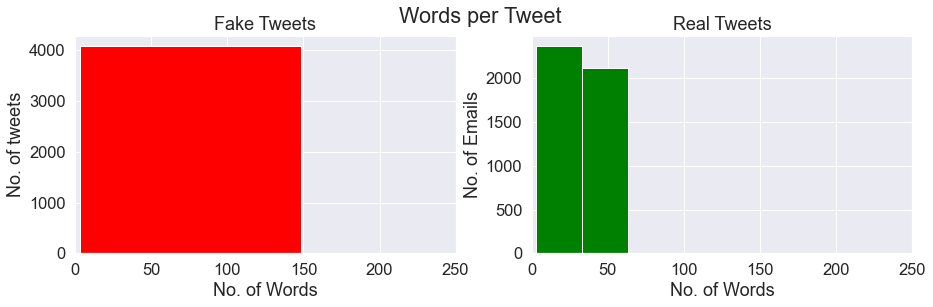

In [15]:
#show word count, character count, and unique word-count of tweets
#1. WORD-COUNT
df['word_count'] = df['tweet'].apply(lambda x: len(str(x).split()))
print("Word Count")
print("Fake:", df[df['label']=="fake"]['word_count'].mean()) #Fake Tweets
print("Real:", df[df['label']=="real"]['word_count'].mean()) #Real Tweets
print("========")

#2. CHARACTER-COUNT
df['char_count'] = df['tweet'].apply(lambda x: len(str(x)))
print("Character Count")
print("Fake:", df[df['label']=="fake"]['char_count'].mean()) #Spam email
print("Real:", df[df['label']== "real"]['char_count'].mean()) #Ham email
print("========")

#3. UNIQUE WORD-COUNT
df['unique_word_count'] = df['tweet'].apply(lambda x: len(set(str(x).split())))
print("Unique Word Count")
print("Fake:", df[df['label']== "fake"]['unique_word_count'].mean()) #Spam email
print("Real:", df[df['label']== "real"]['unique_word_count'].mean()) #Ham email

#Plotting word-count per email according to label of email
fig,(ax1,ax2)=plt.subplots(1,2,figsize=(15,4))
train_words=df[df['label']=="fake"]['word_count']
ax1.hist(train_words,color='red')
ax1.set_title('Fake Tweets')
ax1.set_xlim([0,250])
ax1.set_xlabel('No. of Words')
ax1.set_ylabel('No. of tweets')
train_words=df[df['label']=="real"]['word_count']
ax2.hist(train_words,color='green')
ax2.set_title('Real Tweets')
ax2.set_xlim([0,250])
ax2.set_xlabel('No. of Words')
ax2.set_ylabel('No. of Emails')
fig.suptitle('Words per Tweet')
plt.show()

### Graph of word frequency of tweet text data

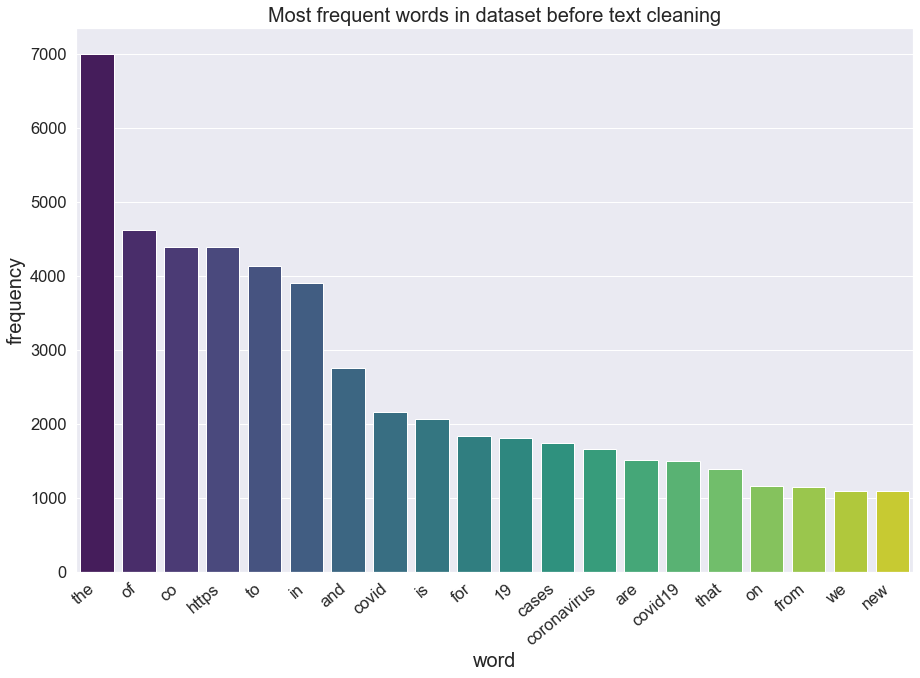

In [7]:
#define function to vectorize text and calculate the most frequent text in tweet text data
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in tweet text data before text cleaning
common_words = get_top_n_words(df['tweet'], 20)
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
#plot graph to show frequency of 20 most frequent words in email text data before text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="tweet", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in dataset before text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()

In [8]:
#define a class, TextCounts to analyze the tweet text attribute
class TextCounts(BaseEstimator, TransformerMixin):
    
    def count_regex(self, pattern, tweet):
        return len(re.findall(pattern, tweet))
    
    def fit(self, X, y=None, **fit_params):
        # fit method is used when specific operations need to be done on the train data, but not on the test data
        return self
    
    def transform(self, X, **transform_params):
        #count the number of words in each tweet
        count_words = X.apply(lambda x: self.count_regex(r'\w+', x)) 
        df = pd.DataFrame({'count_words': count_words})
        return df
    
#define object of TestCounts class
tc = TextCounts()
#define new dataframe to store result of analysis of tweet
df_eda = tc.fit_transform(df.tweet)
df_eda['label'] = df.label

### Graph of distribution of number of words in each real and fake tweet

Descriptive stats for count_words
---------------------------------
        count       mean        std  min   25%   50%   75%     max
label                                                             
fake   3060.0  23.908170  34.115811  3.0  14.0  19.0  29.0  1502.0
real   3360.0  35.779464  11.644398  6.0  26.0  37.0  45.0    65.0


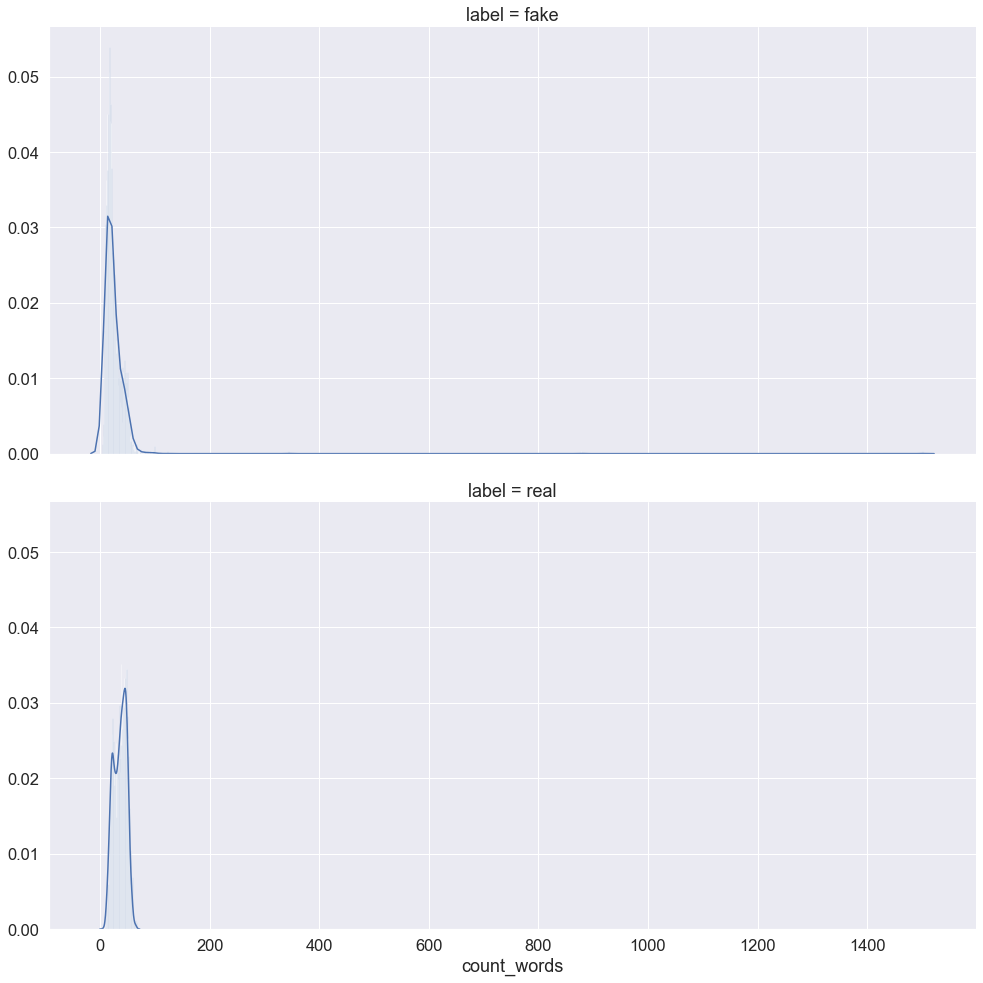

In [9]:
#define function to display graph to visualize word count of spam and ham email
def show_dist(df, col):
    print('Descriptive stats for {}'.format(col))
    print('-'*(len(col)+22))
    print(df.groupby('label')[col].describe())
    bins = np.arange(df[col].min(), df[col].max() + 1)
    g = sns.FacetGrid(df, row='label', size=7, aspect=2)
    g = g.map(sns.distplot, col, kde=True, norm_hist=True, bins=bins)
    plt.style.use("seaborn-bright")
    plt.show()
    
#plot the graph of word count in each email
show_dist(df_eda, 'count_words')

In [10]:
# retriving text column and label column from dataset as only these 2 column are needed for model training
df2 = df[["tweet","label"]]
df2.head(5)

,tweet,label
0,The CDC currently reports 99031 deaths. In gen...,real
1,States reported 1121 deaths a small rise from ...,real
2,Politically Correct Woman (Almost) Uses Pandem...,fake
3,#IndiaFightsCorona: We have 1524 #COVID testin...,real
4,Populous states can generate large case counts...,real


### Text Data Preprocessing on Tweet Text Data to Convert Raw Data to Usable Data

1. Remove punctuations mark.
2. Remove all digit or number.
3. Remove stopwords (list of words that do not have any meaning such as a, about, above, etc.).
4. Change multiple spaces into single space.
5. Remove all special characters. (ex: star symbol)
6. Perform lemmatization on the text data to revert the words to its root words.
7. Replacing shorten words such as "re" and "fw" to "reply" and "forward" respective.
8. Remove unwanted words such as "subject" that does not provide any meaning to the text.
9. Lowercase all character in email text data.

- A class is define with all the text processing technique and it is applied to the tweet text data

In [11]:
#define a CleanText class to perform data cleaning on tweet text data from data set
class CleanText(BaseEstimator, TransformerMixin):
    #replacing the shorten word "re" with "reply"
    #def replace_re(self, input_text):
        # counter = 1
        # if counter ==1:
        #     print(counter)
        #     print(re.sub(r'\bre\b', "reply", input_text))
        #return re.sub(r'\bre\b', "reply", input_text)
    
    #remove all links from tweet 
    def remove_links(self, input_text):
        return re.sub(r'https?:\/\/\S+', '', input_text)
    
    #remove all mentions from tweet 
    def remove_mentions(self, input_text):
        return re.sub(r'@[A-Za-z0-9]+','', input_text)
    
    #remove all retweets from tweet 
    def remove_RT(self, input_text):
        return re.sub(r'RT[\s]+','', input_text)
    
    #remove all hashtags from tweet 
    def remove_hash(self, input_text):
        return re.sub(r'#','', input_text)
    
    #remove all punctuation from tweet 
    def remove_punctuation(self, input_text):
        # Make translation table
        punct = string.punctuation
        trantab = str.maketrans(punct, len(punct)*' ')  # Every punctuation symbol will be replaced by a space
        return input_text.translate(trantab)
    
    #remove all digit from tweet text data
    #def remove_digits(self, input_text):
        #return re.sub('\d+', '', input_text)
    
    #change all letter in tweet text data to lowercase
    def to_lower(self, input_text):
        return input_text.lower()
    
    #remove of leading/trailing whitespace 
    def remove_space(self, input_text):
        return input_text.strip()
    
    #remove extra spaces
    def remove_extra_space(self, input_text):
        return re.sub(r'\s+', ' ', input_text, flags=re.I)
    
    #remove special character
    def remove_special_char(self, input_text):
        return re.sub(r'\W', ' ' , input_text)
    
    #remove all stopwords such as to, i, me, etc. from tweet
    def remove_stopwords(self, input_text):
        stopwords_list = stopwords.words('english')
        # Some words which might indicate a certain sentiment are kept via a whitelist
        whitelist = ["n't", "not", "no"]
        words = input_text.split() 
        clean_words = [word for word in words if (word not in stopwords_list or word in whitelist) and len(word) > 1] 
        return " ".join(clean_words)

    
    #perform lemmatization on each word in tweet to return each word back to its root word without changing the meaning of the word
    def word_lemmatization(self, input_text):
        lemmatizer = WordNetLemmatizer()
        words = input_text.split()
        lemmed_words = [lemmatizer.lemmatize(word) for word in words]
        return " ".join(lemmed_words)
     

    def fit(self, X, y=None, **fit_params):
        return self

    #apply each function in CleanText class to the text dataframe
    def transform(self, X, **transform_params):
        clean_X = X.apply(self.remove_links).apply(self.remove_mentions).apply(self.remove_RT).apply(
            self.remove_hash).apply(self.remove_punctuation).apply(
            self.to_lower).apply(self.remove_space).apply(self.remove_extra_space).apply(
            self.remove_special_char).apply(self.remove_stopwords).apply(self.word_lemmatization) #.apply(self.remove_digits)
        
        #store process output and original text (using first row of tweet)
        output = [X[0]]
        #details of output of each step in process of data proprocessing
        output_description = ["\nOrginal Text:-\n","\nAfter removing all mentions, RTs, links and tags:-\n", "\nAfter removing all punctuation marks, all digits, and changing all letters to lower case:-\n",
                            "\nAfter removing trailing/leading spaces, extra spaces between words and special characters:-\n",
                            "\nAfter removing stopwords and unwanted words (which is the word \"subject\"):-\n", "\nAfter lemmenization of text data:-\n"]
        #change first row of tweet to dataframe Series as this class only works on Series object
        X_example = pd.Series(X[45])
        #apply each step of data preprocessing and store into output array for display
        X_example_clean = X_example.apply(self.remove_hash).apply(self.remove_links).apply(self.remove_mentions).apply(self.remove_RT)
        output.append(X_example_clean[0])
        #.apply(self.remove_digits)
        X_example_clean = X_example_clean.apply(self.remove_punctuation).apply(self.to_lower)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.remove_space).apply(self.remove_extra_space).apply(self.remove_special_char)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.remove_stopwords)
        output.append(X_example_clean[0])
        X_example_clean = X_example_clean.apply(self.word_lemmatization)
        output.append(X_example_clean[0])
        #iterate through each item in both output description and output array and display item accordingly to display output in each data preprocessing step
        print("Text Data Preprocessing Output:-")
        for i in range(len(output)):
            print(output_description[i], output[i], "\n\n==========================================================================================================")

        return clean_X


In [12]:

#define object of CleantText class
ct = CleanText()
#display each output of each step of data preprocessing
sr_clean = ct.fit_transform(df2.tweet)

Text Data Preprocessing Output:-

Orginal Text:-
 The CDC currently reports 99031 deaths. In general the discrepancies in death counts between different sources are small and explicable. The death toll stands at roughly 100000 people today. 


After removing all mentions, RTs, links and tags:-
 IndiaFightsCorona New Recoveries in India have exceeded the New Cases for 5 consecutive days. COVID19  


After removing all punctuation marks, all digits, and changing all letters to lower case:-
 indiafightscorona new recoveries in india have exceeded the new cases for 5 consecutive days  covid19  


After removing trailing/leading spaces, extra spaces between words and special characters:-
 indiafightscorona new recoveries in india have exceeded the new cases for 5 consecutive days covid19 


After removing stopwords and unwanted words (which is the word "subject"):-
 indiafightscorona new recoveries india exceeded new cases consecutive days covid19 


After lemmenization of text data:-
 indi

In [13]:
#display 5 random data of the tweet that has gone through data cleaning
print("Sample of data after data cleaning (5 rows):-\n",sr_clean.sample(5))

#check if there any rows from the dataset has does not have any words left for tweet attribute
empty_clean = sr_clean == ''
print('\n{} email have zero words after going though text cleaning.'.format(sr_clean[empty_clean].count()))

#display an example of original tweet (before cleaning) and cleaned tweet (after cleaning)
print("\n===========================================================")
print("Original Text (before text cleaning):-\n", df2.tweet[45])
print("\n===========================================================")
print("Cleaned Text (after text cleaning):-\n", sr_clean[45])

Sample of data after data cleaning (5 rows):-
 2754    say 2008 book end day predicted current corona...
2525    florida also reported record number case today...
1057    coronavirusupdates state wise detail total con...
1041    indiafightscorona 75 new recovered case report...
4526    said testing capacity still severely constrain...
Name: tweet, dtype: object

0 email have zero words after going though text cleaning.

Original Text (before text cleaning):-
 #IndiaFightsCorona New Recoveries in India have exceeded the New Cases for 5 consecutive days. #COVID19 https://t.co/IWV0Eym3HD

Cleaned Text (after text cleaning):-
 indiafightscorona new recovery india exceeded new case consecutive day covid19


### Writing cleaned tweet and the label of the tweet to new csv file

In [14]:
#define a new dataframe to store the cleaned tweet and real / fake label value of tweet
df_cleaned = pd.DataFrame({'clean_tweet': sr_clean, 'label': df2["label"]})
df_cleaned.columns.tolist()
df_cleaned.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6420 entries, 0 to 6419
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   clean_tweet  6420 non-null   object  
 1   label        6420 non-null   category
dtypes: category(1), object(1)
memory usage: 56.6+ KB


In [15]:
#Drop rows that has tweet with no words after text preprocessing
df_cleaned.drop(df_cleaned[df_cleaned.clean_tweet == ""].index, inplace=True)
df_cleaned.info()

#write cleaned tweet and label of tweet to new csv file
df_cleaned.to_csv("cleaned_real_fake_dataset.csv", index=False)
df_cleaned.head(5)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 6420 entries, 0 to 6419
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype   
---  ------       --------------  -----   
 0   clean_tweet  6420 non-null   object  
 1   label        6420 non-null   category
dtypes: category(1), object(1)
memory usage: 106.7+ KB


,clean_tweet,label
0,cdc currently report 99031 death general discr...,real
1,state reported 1121 death small rise last tues...,real
2,politically correct woman almost us pandemic e...,fake
3,indiafightscorona 1524 covid testing laborator...,real
4,populous state generate large case count look ...,real


### Analyze Tweet Text Data after Text Preprocessing was performed on Email Text Data
- Plot text frequency graph of email text data after text data preprocessing

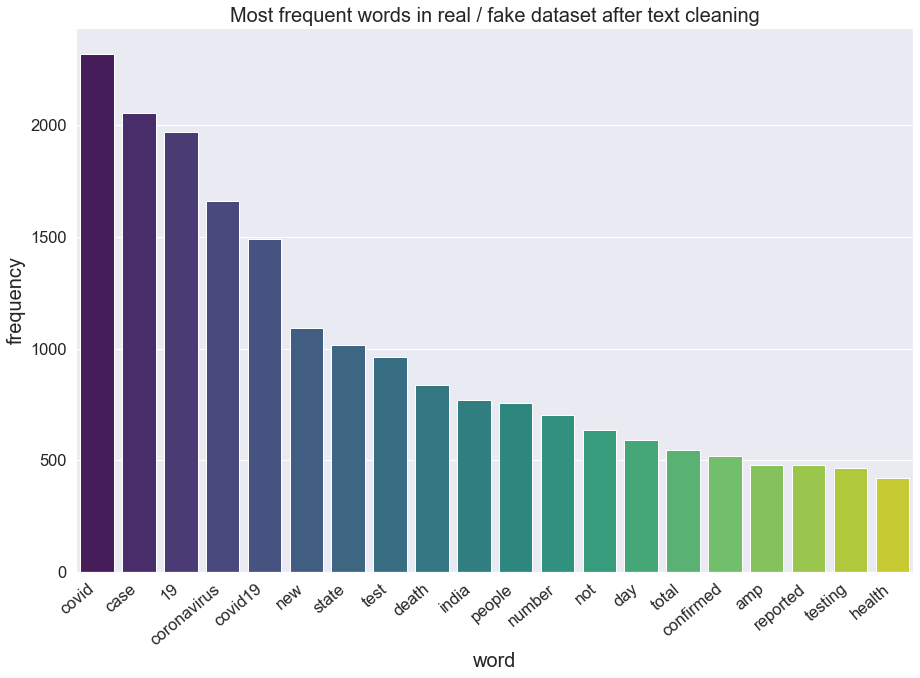

In [16]:
#define function to vectorize text and calculate the most frequent text in email text data (after text preprocessing)
def get_top_n_words(corpus, n=None):
    vec = CountVectorizer().fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

#get 20 most frequent words in email text data after text cleaning
common_words = get_top_n_words(df_cleaned['clean_tweet'], 20)
df1 = pd.DataFrame(common_words, columns = ['tweet' , 'count'])
#plot graph to show frequency of 20 most frequent words in email text data after text cleaning
fig, ax = plt.subplots(figsize=(15, 10))
sns.barplot(x="tweet", y="count", data=df1, palette="viridis", ax=ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation=40, ha="right")
plt.title("Most frequent words in real / fake dataset after text cleaning", fontsize=20)
plt.ylabel("frequency", fontsize=20)
plt.xlabel("word", fontsize=20)
plt.show()